In [127]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import scipy.sparse as sparse
%matplotlib inline
from implicit.als import AlternatingLeastSquares

In [128]:
!dir tmpdata

 Том в устройстве D не имеет метки.
 Серийный номер тома: 3EB1-D609

 Содержимое папки d:\.m2\netology\courses\course06\004\tmpdata

16.06.2019  23:50    <DIR>          .
16.06.2019  23:50    <DIR>          ..
16.06.2019  21:54        13 709 347 bookmarks.dat
16.06.2019  21:54         6 904 084 bookmark_tags.dat
16.06.2019  21:54             5 365 readme.txt
16.06.2019  21:54           922 629 tags.dat
16.06.2019  21:40     1 642 981 585 usersha1-artmbid-artname-plays.tsv
16.06.2019  21:54           413 448 user_contacts-timestamps.dat
16.06.2019  21:54           479 222 user_contacts.dat
16.06.2019  21:54        13 716 140 user_taggedbookmarks-timestamps.dat
16.06.2019  21:54        15 652 892 user_taggedbookmarks.dat
               9 файлов  1 694 784 712 байт
               2 папок  145 856 368 640 байт свободно


In [129]:
bookmarks = pd.read_csv('tmpdata/bookmarks.dat', sep='\t', encoding='ANSI')
bookmark_tags = pd.read_csv('tmpdata/bookmark_tags.dat', sep='\t', encoding='ANSI')
tags = pd.read_csv('tmpdata/tags.dat', sep='\t', encoding='ANSI')
user_contacts_timestamps = pd.read_csv('tmpdata/user_contacts-timestamps.dat', sep='\t', encoding='ANSI')
user_taggedbookmarks_timestamps = pd.read_csv('tmpdata/user_taggedbookmarks-timestamps.dat', sep='\t', encoding='ANSI')

In [130]:
bookmarks.head(10)

,id,md5,title,url,md5Principal,urlPrincipal
0,1,ab4954b633ddaf5b5bba6e9b71aa6b70,IFLA - The official website of the Internation...,http://www.ifla.org/,7f431306c428457bc4e12b15634484f,www.ifla.org
1,2,2221e9cd106d269dd34682666f576fa3,gcdp-e.pdf (application/pdf Object),http://archive.ifla.org/VII/s14/nd1/gcdp-e.pdf,1ef8cfcfe968101fa9b4e301847503d4,archive.ifla.org
2,7,c97c571dadaddbbb493126a0d4d01ba3,EdSelect,http://www.edselect.com/,792fd7eb20143386d0c4eb193c6124d,www.edselect.com
3,8,25bfe8dca0ef263ec9c341b9f16c38b5,Cool Canada (Collections Canada),http://www.collectionscanada.gc.ca/cool/index-...,6fce4f6391516f0732531d9cfacda5b7,www.collectionscanada.gc.ca
4,9,c97284629e17b8e2861afaacd59918bc,Kidsreads.com,http://www.kidsreads.com/,5854ce8404857a45373eea01a3d98000,www.kidsreads.com
5,10,5a9bdcf2a5ee18c210cdce663b631340,Kidsreads.com -- GREAT BOOKS FOR BOYS,http://www.kidsreads.com/features/great-books-...,5854ce8404857a45373eea01a3d98000,www.kidsreads.com
6,11,d49b0ae16c137b452a148488a400924f,Moodle ::|:: SDUSD Educational Technology,http://moodle.sandi.net/,c40a51ae904e35fbf4e5eb2fc15f95c,moodle.sandi.net
7,14,67e4e670037229c5f36d9450001d3e97,CountryReports.org вЂ” Country Information,http://countryreports.org/,b2afa8146708c6c9957c7e4db29a7814,countryreports.org
8,15,4e72a2a5f48b1a6d2d1c6e8e3e8eb399,"Some of the Best Books, K-12",http://www.kn.att.com/wired/fil/pages/listbest...,fcaf87c40c53c57de95abb9678ca138a,www.kn.att.com
9,16,2c344d706ad1ebdfe0545a26e483b017,Education World В®: Lesson Plan: Lessons from ...,http://www.educationworld.com/a_lesson/lesson2...,78e74cba021bd118110d7d5347209493,www.educationworld.com


In [131]:
bookmark_tags.head()

,bookmarkID,tagID,tagWeight
0,1,2,276
1,1,206,48
2,1,208,165
3,1,272,55
4,1,459,67


In [132]:
tags.head()

,id,value
0,1,collection_development
1,2,library
2,3,collection
3,4,development
4,5,lesson_plan


In [133]:
user_contacts_timestamps.head()

,userID,contactID,timestamp
0,8,28371,1286151259000
1,8,40306,1286101989000
2,8,85279,1285981848000
3,8,91764,1286225027000
4,8,97723,1286846913000


In [134]:
user_taggedbookmarks_timestamps.head()

,userID,bookmarkID,tagID,timestamp
0,8,1,1,1289255362000
1,8,2,1,1289255159000
2,8,7,1,1289238901000
3,8,7,6,1289238901000
4,8,7,7,1289238901000


In [135]:
user_taggedbookmarks_timestamps.nunique()

userID          1867
bookmarkID     69223
tagID          40897
timestamp     104093
dtype: int64

In [136]:
user_taggedbookmarks = user_taggedbookmarks_timestamps.join(bookmarks.set_index('id'), on='bookmarkID').reset_index(drop=True)
user_taggedbookmarks.dropna(inplace=True)

In [137]:
user_taggedbookmarks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437366 entries, 0 to 437592
Data columns (total 9 columns):
userID          437366 non-null int64
bookmarkID      437366 non-null int64
tagID           437366 non-null int64
timestamp       437366 non-null int64
md5             437366 non-null object
title           437366 non-null object
url             437366 non-null object
md5Principal    437366 non-null object
urlPrincipal    437366 non-null object
dtypes: int64(4), object(5)
memory usage: 33.4+ MB


In [138]:
user_taggedbookmarks.head()

,userID,bookmarkID,tagID,timestamp,md5,title,url,md5Principal,urlPrincipal
0,8,1,1,1289255362000,ab4954b633ddaf5b5bba6e9b71aa6b70,IFLA - The official website of the Internation...,http://www.ifla.org/,7f431306c428457bc4e12b15634484f,www.ifla.org
1,8,2,1,1289255159000,2221e9cd106d269dd34682666f576fa3,gcdp-e.pdf (application/pdf Object),http://archive.ifla.org/VII/s14/nd1/gcdp-e.pdf,1ef8cfcfe968101fa9b4e301847503d4,archive.ifla.org
2,8,7,1,1289238901000,c97c571dadaddbbb493126a0d4d01ba3,EdSelect,http://www.edselect.com/,792fd7eb20143386d0c4eb193c6124d,www.edselect.com
3,8,7,6,1289238901000,c97c571dadaddbbb493126a0d4d01ba3,EdSelect,http://www.edselect.com/,792fd7eb20143386d0c4eb193c6124d,www.edselect.com
4,8,7,7,1289238901000,c97c571dadaddbbb493126a0d4d01ba3,EdSelect,http://www.edselect.com/,792fd7eb20143386d0c4eb193c6124d,www.edselect.com


In [163]:
#Количество проставленных тегов - будем считать оценкой
# готовим данные

In [164]:
user_taggedbookmarks = user_taggedbookmarks[['userID', 'bookmarkID']]

In [165]:
data = user_taggedbookmarks_timestamps.groupby(['userID', 'bookmarkID']).agg({'tagID': 'count'})

In [166]:
data = data.reset_index()

In [167]:
data.columns = ['userID','bookmarkID','tags']

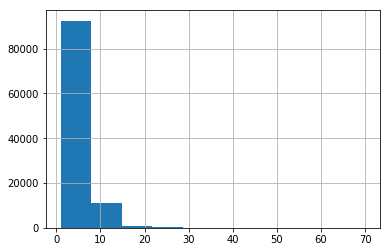

In [168]:
data.tags.hist()

In [169]:
data[data['userID']==8].head()

,userID,bookmarkID,tags
0,8,1,1
1,8,2,1
2,8,7,3
3,8,8,3
4,8,9,2


In [170]:
data1 = data.join(bookmarks[['id', 'title']].set_index('id'), on='bookmarkID').reset_index(drop=True)
data1.dropna(inplace=True)
data1 = data1.loc[data.tags != 0]

In [171]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104732 entries, 0 to 104798
Data columns (total 4 columns):
userID        104732 non-null int64
bookmarkID    104732 non-null int64
tags          104732 non-null int64
title         104732 non-null object
dtypes: int64(3), object(1)
memory usage: 4.0+ MB


In [173]:
data1['user_indx'] = data1['userID'].astype("category").cat.codes
data1['bookmark_indx'] = data1['title'].astype("category").cat.codes

In [174]:
data1.head()

,userID,bookmarkID,tags,title,user_indx,bookmark_indx
0,8,1,1,IFLA - The official website of the Internation...,0,25533
1,8,2,1,gcdp-e.pdf (application/pdf Object),0,60581
2,8,7,3,EdSelect,0,16402
3,8,8,3,Cool Canada (Collections Canada),0,12747
4,8,9,2,Kidsreads.com,0,28596


In [177]:
bookmark_lookup = data1[['bookmark_indx', 'title']].drop_duplicates()

In [178]:
bookmark_lookup.head()

,bookmark_indx,title
0,25533,IFLA - The official website of the Internation...
1,60581,gcdp-e.pdf (application/pdf Object)
2,16402,EdSelect
3,12747,Cool Canada (Collections Canada)
4,28596,Kidsreads.com


In [179]:
data1 = data1.drop(['userID', 'bookmarkID', 'title'], axis=1)

In [190]:
#Готовим матрицу

In [191]:
rows = data1.user_indx.astype(int)
cols = data1.bookmark_indx.astype(int)
tags = data1.tags.astype(int)
usersCount = len(data1.user_indx.unique())
bookmarCount = len(data1.bookmark_indx.unique())
print(usersCount, bookmarCount)

1867 66167


In [192]:
print(len(tags), len(cols), len(rows))

104732 104732 104732


In [193]:
data_sparse = sparse.csr_matrix((tags, (cols, rows)), shape=(bookmarCount, usersCount))

In [194]:
model = AlternatingLeastSquares(factors=50)
model.fit(data_sparse)

100%|██████████| 15.0/15 [00:00<00:00, 19.03it/s]


In [195]:
userid = 1

user_items = data_sparse.T.tocsr()
recommendations = model.recommend(userid, user_items)

In [196]:
recommendations

[(53868, 0.042639934),
 (34486, 0.03790721),
 (54891, 0.036406737),
 (59635, 0.035775095),
 (11581, 0.0337418),
 (53880, 0.033411004),
 (52771, 0.03278278),
 (40900, 0.032214515),
 (58245, 0.031426027),
 (5404, 0.03127609)]

In [197]:
for r in recommendations:
    print(bookmark_lookup[bookmark_lookup['bookmark_indx'] == r[0]]['title'].values[0])

VoiceThread - Group conversations around images, documents, and videos
NetSmartz.org
Welcome to CanLit for Kids
connection education with how young people use technology
Classroom 2.0
Voki Home
Untitled Document
Resources for School Librarians
YouTube - Wikis in Plain English
AllThingsPLC вЂ” Research, education tools and blog for building a professional learning community


In [198]:
itemid = 53868
related = model.similar_items(itemid)

In [199]:
related

[(53868, 0.5720958),
 (4280, 0.5492722),
 (6896, 0.5492721),
 (10142, 0.5492721),
 (55113, 0.5492721),
 (1219, 0.5492721),
 (44509, 0.5492721),
 (54553, 0.5492721),
 (25167, 0.5492721),
 (58533, 0.5492721)]

In [200]:
for a in related:
    print(bookmark_lookup[bookmark_lookup['bookmark_indx'] == a[0]]['title'].values[0])

VoiceThread - Group conversations around images, documents, and videos
ALA | AASL Standards for the 21st-Century Learner
Astronomy and Space Exploration — FactMonster.com
CMMR - Native American Resources
Welcome to the Planets
16 Free JavaScript Solutions for Displaying Your Images
SpaceWeather.com -- News and information about meteor showers, solar flares, auroras, and near-Earth asteroids
Web Lab Directory
HubbleSite -- Out of the ordinary...out of this world.
ZOOM ASTRONOMY - Enchanted Learning Software
